## _Track Evaluation_

1. Track Formation using DBScan or CCL, see **_trkx_from_gnn.py_** with its code breakdown in **_trkx_from_gnn.ipynb_**
2. Track Evaluation using Two-way Matching, see **_eval_reco_trkx.py_** with its code breakdown in **_eval_reco_trkx.ipynb_**
    
&nbsp;    
_**Problem:** Our track candidates has `track_id=-1` to hold unused hits, they needs to removed otherwise track purity goes above 100%_

_**Note:** Above scripts are adapted from `gnn4itk/scripts` with the same names._

In [2]:
import glob, os, sys, yaml

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import time

In [5]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial

In [6]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
sys.path.append('..')

In [8]:
from src import SttTorchDataReader, SttCSVDataReader
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

In [9]:
raw_inputdir="../run_all/fwp_gnn_processed/pred"  # output of GNN stage as in test/pred
rec_inputdir="../run_all/fwp_gnn_segmenting/seg"  # output of trkx_from_gnn.sh
outputdir="../run_all/fwp_gnn_segmenting/eval"    # output of eval_reco_trkx.sh

In [14]:
### _Track Formation_

In [ ]:
def label_graph(graph, score_cut=0.8, save_dir="datasets/quickstart_track_building_processed"):

    os.makedirs(save_dir, exist_ok=True)

    edge_mask = graph.scores > score_cut

    row, col = graph.edge_index[:, edge_mask]
    edge_attr = np.ones(row.size(0))

    N = graph.x.size(0)
    sparse_edges = sps.coo_matrix((edge_attr, (row.numpy(), col.numpy())), (N, N))

    _, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
    graph.labels = torch.from_numpy(candidate_labels).long()

    torch.save(graph, os.path.join(save_dir, graph.event_file[-4:]))

### _(1) - GNN Raw Events_

In [10]:
# event to investigate
event_id = 10256

In [11]:
raw_reader = SttTorchDataReader(raw_inputdir)

In [12]:
graph = raw_reader.read(event_id)

In [13]:
graph

Data(x=[48, 3], pid=[48], layers=[48], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000010256', hid=[48], pt=[48], vertex=[48, 3], charge=[48], pdgcode=[48], ptheta=[48], peta=[48], pphi=[48], modulewise_true_edges=[2, 45], layerwise_true_edges=[2, 57], edge_index=[2, 131], y_pid=[131], scores=[262])

In [12]:
# number of particles
graph.pid.unique()

tensor([5., 6., 7.], dtype=torch.float64)

In [13]:
# hit features
r, phi, ir = graph.x.T

# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

# compensate scaling
ir = ir.detach().numpy()*100

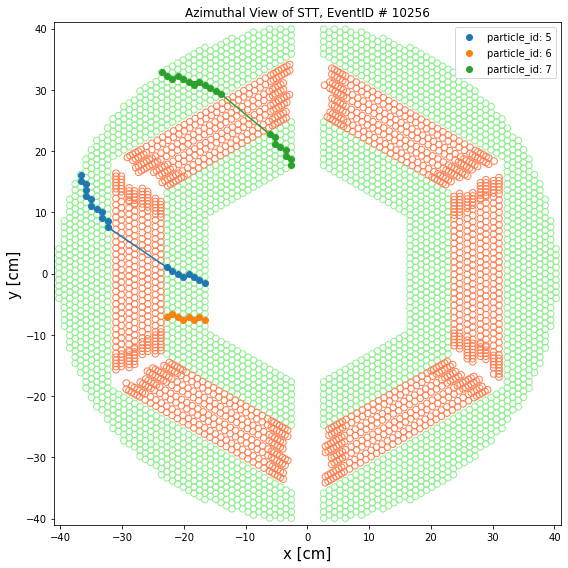

In [14]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
e_id = int(graph.event_file[-10:])
p_ids = np.unique(graph.pid)

for pid in p_ids:
    idx = graph.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

In [106]:
# prepare truth information
raw_data = graph

In [107]:
truth = pd.DataFrame({'hit_id': raw_data.hid.numpy(), 'particle_id': raw_data.pid.int().numpy()},
                      columns=['hit_id', 'particle_id'])

particles = pd.DataFrame({'particle_id': raw_data.pid.int().numpy(),
                           'pt': raw_data.pt.numpy(),
                           'vx': raw_data.vertex[:,0].numpy(),
                           'vy': raw_data.vertex[:,1].numpy(),
                           'vz': raw_data.vertex[:,2].numpy(),
                           'q': raw_data.charge.numpy(),
                           'pdgcode': raw_data.pdgcode.numpy(),
                           'ptheta': raw_data.ptheta.numpy(),
                           'peta': raw_data.peta.numpy(),
                           'pphi': raw_data.pphi.numpy()
                           },
                          columns=['particle_id', 'pt', 'vx', 'vy', 'vz', 'q', 'pdgcode', 'ptheta', 'peta', 'pphi']
                          ).drop_duplicates(subset=['particle_id'])

### _(2) Tracks from GNN_

In [112]:
# reco_track_path = "run/trkx_from_gnn"
reco_trkx_reader = SttTorchDataReader(rec_inputdir)

In [113]:
# fetch a single event
reco_data = reco_trkx_reader(event_id)

In [114]:
reco_data.head()

,hit_id,track_id
0,40,0
1,41,0
2,1,0
3,42,0
4,29,1


In [115]:
# number of reco tracks
np.unique(reco_data.track_id.values)

array([0, 1], dtype=int32)

In [116]:
# renaming
reconstructed = reco_data

### _(3) Track Evaluation_

- _Fixing `eval_reco_trkx.py`_

In [117]:
truth.head()

,hit_id,particle_id
0,40,5
1,41,5
2,1,7
3,42,5
4,29,6


In [118]:
particles.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi
0,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308
2,7,0.086906,-0.561839,0.140818,5.17825,-1,-211,0.967701,0.643377,2.041015
4,6,0.084990,-0.561839,0.140818,5.17825,1,2212,0.265083,2.014978,-3.130093


In [119]:
reconstructed.head()

,hit_id,track_id
0,40,0
1,41,0
2,1,0
3,42,0
4,29,1


In [25]:
# number of hits
truth.hit_id.count(), reconstructed.hit_id.count()

(48, 48)

In [26]:
# filter missed hits
reconstructed[reconstructed["track_id"]==-1].hit_id.count()

0

In [27]:
reconstructed[reconstructed["track_id"]==-1].head(10)

,hit_id,track_id


- ALERT: We have -ve `track_id` that was added to keep used hits. As these are not track candidates, so should remove it.

In [28]:
# reconstructed = reconstructed[reconstructed['track_id'] !=-1]

In [29]:
reconstructed.head()

,hit_id,track_id
0,40,0
1,41,0
2,1,0
3,42,0
4,29,1


In [30]:
particles.drop_duplicates(subset=['particle_id'])

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi
0,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308
2,7,0.086906,-0.561839,0.140818,5.17825,-1,-211,0.967701,0.643377,2.041015
4,6,0.084990,-0.561839,0.140818,5.17825,1,2212,0.265083,2.014978,-3.130093


In [31]:
np.unique(particles.particle_id.values)

array([5, 6, 7], dtype=int32)

In [32]:
truth.shape[0], particles.shape[0], reconstructed.shape[0]

(48, 3, 48)

In [33]:
# input to evaluate_reco_tracks()
reco_df = reconstructed
min_hits_truth=7
min_hits_reco=6
min_pt=0.
frac_reco_matched=0.5
frac_truth_matched=0.5

In [34]:
 # just in case particle_id == 0 included in truth.
if 'particle_id' in truth.columns:
    truth = truth[truth.particle_id > 0]

In [35]:
truth.shape

(48, 2)

In [36]:
# get number of spacepoints in each reconstructed tracks
n_reco_hits = reco_df.track_id.value_counts(sort=False)\
    .reset_index().rename(
        columns={"index":"track_id", "track_id": "n_reco_hits"})

- ALERT: `track_id = -1`

In [37]:
n_reco_hits.head()

,track_id,n_reco_hits
0,0,40
1,1,8


In [38]:
# only tracks with a minimum number of spacepoints are considered
n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]

In [39]:
n_reco_hits.head()

,track_id,n_reco_hits
0,0,40
1,1,8


In [40]:
reco_df = reco_df[reco_df.track_id.isin(n_reco_hits.track_id.values)]

In [41]:
reco_df.head()

,hit_id,track_id
0,40,0
1,41,0
2,1,0
3,42,0
4,29,1


In [42]:
reco_df.track_id.unique()

array([0, 1], dtype=int32)

- **Truth Info**

In [43]:
# get number of spacepoints in each particle
hits = truth.merge(particles, on='particle_id', how='left')

In [44]:
hits.head()

,hit_id,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi
0,40,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308
1,41,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308
2,1,7,0.086906,-0.561839,0.140818,5.17825,-1,-211,0.967701,0.643377,2.041015
3,42,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308
4,29,6,0.084990,-0.561839,0.140818,5.17825,1,2212,0.265083,2.014978,-3.130093


In [45]:
n_true_hits = hits.particle_id.value_counts(sort=False).reset_index().rename(
    columns={"index":"particle_id", "particle_id": "n_true_hits"})

In [46]:
n_true_hits.head()

,particle_id,n_true_hits
0,5,20
1,7,20
2,6,8


In [47]:
# only particles leaves at least min_hits_truth spacepoints 
# and with pT >= min_pt are considered.
particles = particles.merge(n_true_hits, on=['particle_id'], how='left')

In [48]:
is_trackable = particles.n_true_hits >= min_hits_truth

In [49]:
is_trackable

0    True
1    True
2    True
Name: n_true_hits, dtype: bool

In [50]:
# event has 3 columnes [track_id, particle_id, hit_id]
event = pd.merge(reconstructed, truth, on=['hit_id'], how='left')

In [51]:
event.track_id.unique()

array([0, 1], dtype=int32)

In [52]:
n_reco_hits.shape, n_true_hits.shape

((2, 2), (3, 2))

In [53]:
# n_common_hits and n_shared should be exactly the same 
# for a specific track id and particle id

# Each track_id will be assigned to multiple particles.
# To determine which particle the track candidate is matched to, 
# we use the particle id that yields a maximum value of n_common_hits / n_reco_hits,
# which means the majority of the spacepoints associated with the reconstructed
# track candidate comes from that true track.
# However, the other way may not be true.
reco_matching = event.groupby(['track_id', 'particle_id']).size()\
    .reset_index().rename(columns={0:"n_common_hits"})

In [54]:
reco_matching.head(10)

,track_id,particle_id,n_common_hits
0,0,5,20
1,0,7,20
2,1,6,8


In [55]:
# Each particle will be assigned to multiple reconstructed tracks
truth_matching = event.groupby(['particle_id', 'track_id']).size()\
    .reset_index().rename(columns={0:"n_shared"})

In [56]:
truth_matching.head(10)

,particle_id,track_id,n_shared
0,5,0,20
1,6,1,8
2,7,0,20


In [57]:
# add number of hits to each of the maching dataframe
reco_matching = reco_matching.merge(n_reco_hits, on=['track_id'], how='left')
truth_matching = truth_matching.merge(n_true_hits, on=['particle_id'], how='left')

In [58]:
reco_matching.head(10)

,track_id,particle_id,n_common_hits,n_reco_hits
0,0,5,20,40
1,0,7,20,40
2,1,6,8,8


In [59]:
truth_matching.head(10)

,particle_id,track_id,n_shared,n_true_hits
0,5,0,20,20
1,6,1,8,8
2,7,0,20,20


In [60]:
# calculate matching fraction
reco_matching = reco_matching.assign(
    purity_reco=np.true_divide(reco_matching.n_common_hits, reco_matching.n_reco_hits))
truth_matching = truth_matching.assign(
    purity_true = np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits))

In [61]:
reco_matching.head(10)

,track_id,particle_id,n_common_hits,n_reco_hits,purity_reco
0,0,5,20,40,0.5
1,0,7,20,40,0.5
2,1,6,8,8,1.0


In [62]:
truth_matching.head(10)

,particle_id,track_id,n_shared,n_true_hits,purity_true
0,5,0,20,20,1.0
1,6,1,8,8,1.0
2,7,0,20,20,1.0


In [63]:
# select the best match
reco_matching['purity_reco_max'] = reco_matching.groupby(
    "track_id")['purity_reco'].transform(max)
truth_matching['purity_true_max'] = truth_matching.groupby(
    "track_id")['purity_true'].transform(max)

In [64]:
reco_matching.head(10)

,track_id,particle_id,n_common_hits,n_reco_hits,purity_reco,purity_reco_max
0,0,5,20,40,0.5,0.5
1,0,7,20,40,0.5,0.5
2,1,6,8,8,1.0,1.0


In [65]:
truth_matching.head(10)

,particle_id,track_id,n_shared,n_true_hits,purity_true,purity_true_max
0,5,0,20,20,1.0,1.0
1,6,1,8,8,1.0,1.0
2,7,0,20,20,1.0,1.0


In [66]:
matched_reco_tracks = reco_matching[
        (reco_matching.purity_reco_max >= frac_reco_matched) \
      & (reco_matching.purity_reco == reco_matching.purity_reco_max)]

In [67]:
matched_reco_tracks

,track_id,particle_id,n_common_hits,n_reco_hits,purity_reco,purity_reco_max
0,0,5,20,40,0.5,0.5
1,0,7,20,40,0.5,0.5
2,1,6,8,8,1.0,1.0


- **ALERT**: _`matched_reco_tracks` should always be less than `n_reco_hits`_

In [68]:
if matched_reco_tracks.shape[0] > n_reco_hits.shape[0]:
    print("shape:", matched_reco_tracks.shape[0], n_reco_hits.shape[0])

shape: 3 2


In [69]:
matched_true_particles = truth_matching[
        (truth_matching.purity_true_max >= frac_truth_matched) \
      & (truth_matching.purity_true == truth_matching.purity_true_max)]

In [70]:
matched_true_particles

,particle_id,track_id,n_shared,n_true_hits,purity_true,purity_true_max
0,5,0,20,20,1.0,1.0
1,6,1,8,8,1.0,1.0
2,7,0,20,20,1.0,1.0


In [71]:
# now, let's combine the two majority criteria
# reconstructed tracks must be in both matched dataframe
# and the so matched particle should be the same
# in this way, each track should be only assigned 
combined_match = matched_true_particles.merge(
    matched_reco_tracks, on=['track_id', 'particle_id'], how='inner')

In [72]:
combined_match

,particle_id,track_id,n_shared,n_true_hits,purity_true,purity_true_max,n_common_hits,n_reco_hits,purity_reco,purity_reco_max
0,5,0,20,20,1.0,1.0,20,40,0.5,0.5
1,6,1,8,8,1.0,1.0,8,8,1.0,1.0
2,7,0,20,20,1.0,1.0,20,40,0.5,0.5


In [73]:
n_reco_tracks = n_reco_hits.shape[0]
n_true_tracks = particles.shape[0]

In [74]:
n_reco_tracks, n_true_tracks

(2, 3)

In [75]:
# For GNN, there are non-negaliable cases where GNN-based
# track candidates are matched to particles not considered as interesting.
# which means there are paticles in matched_pids that do not exist in particles.
matched_pids = np.unique(combined_match.particle_id)

In [76]:
matched_pids

array([5, 6, 7])

In [77]:
is_matched = particles.particle_id.isin(matched_pids).values
n_matched_particles = np.sum(is_matched)

n_matched_tracks = reco_matching[
    reco_matching.purity_reco >= frac_reco_matched].shape[0]
n_matched_tracks_poi = reco_matching[
    (reco_matching.purity_reco >= frac_reco_matched) \
    & (reco_matching.particle_id.isin(particles.particle_id.values))
    ].shape[0]

In [78]:
is_matched

array([ True,  True,  True])

In [79]:
n_matched_particles

3

In [80]:
n_matched_tracks

3

In [81]:
n_matched_tracks_poi

3

In [82]:
n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles
particles = particles.assign(
    is_matched=is_matched,
    is_trackable=is_trackable)

In [83]:
particles

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable
0,5,0.084135,0.251500,-0.063035,5.71085,1,211,0.430073,1.521365,2.928308,20,True,True
1,7,0.086906,-0.561839,0.140818,5.17825,-1,-211,0.967701,0.643377,2.041015,20,True,True
2,6,0.084990,-0.561839,0.140818,5.17825,1,2212,0.265083,2.014978,-3.130093,8,True,True


In [84]:
(n_true_tracks, n_reco_tracks, n_matched_true_tracks, n_matched_reco_tracks, n_duplicated_reco_tracks, n_matched_reco_tracks_poi) = (n_true_tracks, n_reco_tracks, n_matched_particles, n_matched_tracks, n_duplicated_tracks, n_matched_tracks_poi)

### _Examine Output_

In [85]:
print("               Truth tracks: {:>10}".format(n_true_tracks))
print("       Truth tracks matched: {:>10}".format(n_matched_true_tracks))
print("       Reconstructed tracks: {:>10}".format(n_reco_tracks))
print("       Reco. tracks matched: {:>10}".format(n_matched_reco_tracks))
print("Reco. tracks matched to POI: {:>10}".format(n_matched_reco_tracks_poi))
print("    Reco. tracks duplicated: {:>10}".format(n_duplicated_reco_tracks))
print("        Tracking Efficiency: {:>10.4f}%".format(100 * n_matched_true_tracks / n_true_tracks))
print("            Tracking Purity: {:>10.4f}%".format(100 * n_matched_reco_tracks / n_reco_tracks))
print("                  Fake rate: {:>10.4f}%".format(100 - 100 * n_matched_reco_tracks / n_reco_tracks))
print("           Duplication Rate: {:>10.4f}%".format(100 * n_duplicated_reco_tracks / n_reco_tracks))

               Truth tracks:          3
       Truth tracks matched:          3
       Reconstructed tracks:          2
       Reco. tracks matched:          3
Reco. tracks matched to POI:          3
    Reco. tracks duplicated:          0
        Tracking Efficiency:   100.0000%
            Tracking Purity:   150.0000%
                  Fake rate:   -50.0000%
           Duplication Rate:     0.0000%


### _Let's View both True and Reconstructed Event_

In [86]:
true_track = raw_data

In [87]:
# hit features
r, phi, ir = true_track.x.T

# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

# compensate scaling
ir = ir.detach().numpy()*100

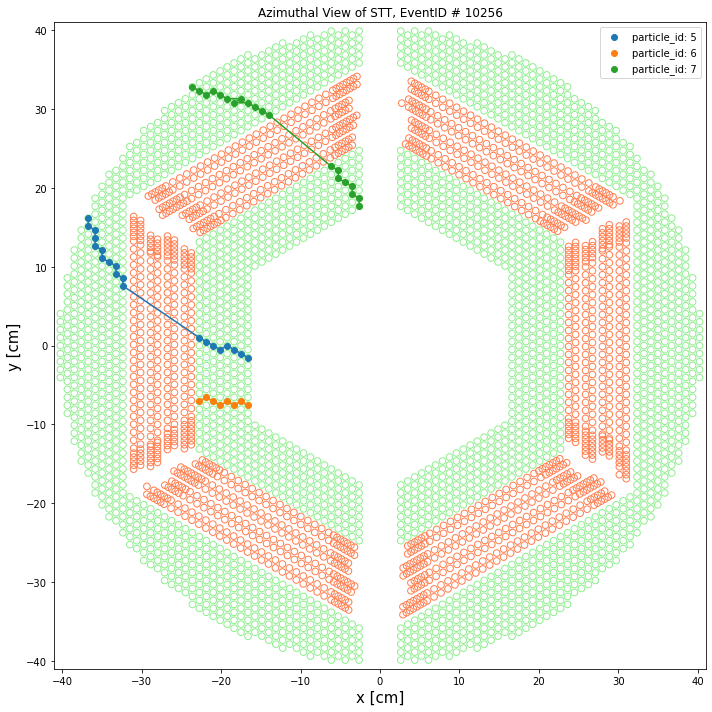

In [110]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_track.event_file[-10:])
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
fig.savefig("true_track.png")

In [89]:
reco_track = reco_data

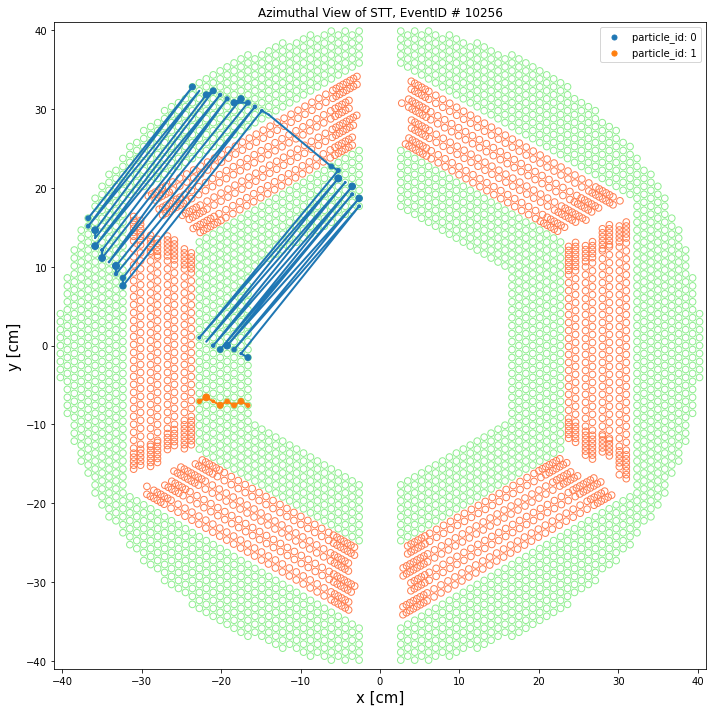

In [111]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_track.track_id)

for tid in t_ids:
    idx = reco_track.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
fig.savefig("reco_track.png")

### _Read HDF5_

In [91]:
import pandas as pd

In [92]:
path = "../run_all/fwp_gnn_segmenting/eval/all_particles.h5"
store = pd.HDFStore(path)

In [93]:
# store.get('data').head()
store['data'].head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


In [94]:
store.close()